# Preprocessing Visium dataset

We have to goals:
1. prepare the image and mask for processing
2. estimate the value of the hyper-parameters which will be used for training

In [406]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import skimage.io
import skimage.filters
import skimage.color
import skimage.morphology
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None

import torch
import numpy as np
import scipy
import collections

### Helper functions

In [408]:
BBOX = collections.namedtuple("BBOX","min_row, min_col, max_row, max_col")
PREPROCESS = collections.namedtuple("PREPROCESS","img roi_mask bbox_original bbox_crop")

def pil_to_numpy_int(pilfile, mode: str = 'L', reduction_factor: int =1):
    """ Open file using pillow, and return numpy array of type int with shape: w,h,channel """
    
    pilobject = PIL.Image.open(pilfile).convert(mode)
    
    # Use PIL.Image.LANCZOS pto revent antialiasing when downsampling
    if reduction_factor != 1:
        w_raw, h_raw = pilobject.size
        w_new = int(w_raw/reduction_factor)
        h_new = int(h_raw/reduction_factor)
        pilobject = pilobject.resize((w_new,h_new), resample=PIL.Image.BILINEAR)  

    return np.array(pilobject)


def rescale_intensity(img_reference, roi_mask, q=(0.01, 99.99)):
    """ Rescale intensity inside ROI to occupy the full range """
    ql, qr = np.percentile(img_reference[roi_mask], q=q)  
    return skimage.exposure.rescale_intensity(img_reference, 
                                              in_range=(ql, qr), 
                                              out_range='dtype')


def find_old_2_new(old, new):
    assert old.shape == new.shape
    x = np.arange(256, dtype=int)
    
    if len(old.shape)==2:
        ch = old.shape[1]
        old_2_new = -1 * np.ones((256,ch), dtype=int)
        
        for c in range(old.shape[1]):
            xp, index = np.unique(old[...,c], return_index=True)
            fp = new[...,c][index]
            old_2_new[...,c] = np.interp(x, xp, fp)
    else:
        old_2_new = -1 * np.ones(256, dtype=int)
        xp, index = np.unique(old, return_index=True)
        fp = new[index]
        old_2_new = np.interp(x, xp, fp)
        
    return old_2_new

        
def compute_sqrt_mse(predictions, roi_mask):
    assert len(predictions.shape) == 4
    assert len(roi_mask.shape) == 2
    n,w,h,c = predictions.shape
    diff = (predictions - predictions[0])*roi_mask[...,None]  # append channel dimension
    mse = np.sum(diff**2, axis=(-1,-2,-3)) / (c * np.sum(roi_mask)) 
    sigma = np.sqrt(mse)
    return sigma

def getLargestCC(mask):
    labels = skimage.measure.label(mask)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def find_bbox(mask):
    assert len(mask.shape) == 2
    row = np.sum(mask, axis=-1) > 0
    col = np.sum(mask, axis=-2) > 0
    max_row = max(np.arange(row.shape[0])*row) + 1
    min_row = row.shape[0] - max(np.arange(start=row.shape[0],stop=0, step=-1)*row)
    max_col = max(np.arange(col.shape[0])*col) + 1
    min_col = col.shape[0] - max(np.arange(start=col.shape[0],stop=0, step=-1)*col)
    return BBOX(min_row=min_row,
                min_col=min_col,
                max_row=max_row,
                max_col=max_col)

def show_video(frames: np.ndarray,
               ref_image: np.ndarray,
               sigma: np.ndarray,
               figsize: tuple = (8, 4),
               interval: int = 50):
    """
    :param video: an ndarray with shape (n_frames, height, width, 3)
    """
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    ax_image = axs[0]
    ax_video = axs[1]
    
    # image
    ax_image.axis('off')
    ax_image.imshow(ref_image)
    ax_image.set_title("ref image")
    
    ax_video.axis('off')
    ax_video.imshow(frames[0, ...])
    ax_video.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        ax_video.imshow(frames[0, ...])
        ax_video.set_title("title")
        
    def animate(i):
        title = 'corrupted prediction, frame={0:3d}, sigma={1:.3f}'.format(i,sigma[i])
        ax_video.imshow(frames[i, ...])
        ax_video.set_title(title)
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=frames.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

## Use a small thumbnail to estimate the parameters

Define the parameters

In [409]:
file_1 = "191203_5k_CN021_2_Allen_HE_AM_SNA-Spot000001.jpg"
file_2 = "191206_5K_CN026_1_allen_HE_SN_AM-Spot000001.jpg"
file_3 = "200128_Allen_V19T26_ID098_AM-Spot000001.jpg"
file_4 = "200128_Allen_V4_V19T26_ID098_A-Spot000001.jpg"

file=file_2
mode = "RGB"
reduction_factor=10

Obtain a coarse version of the image to perfrom the parameter estimation.

In [410]:
small_img = pil_to_numpy_int(file, 
                             mode=mode, 
                             reduction_factor=reduction_factor)

print("shape and type -->", small_img.shape, small_img.dtype)
print(small_img.flags)

shape and type --> (3174, 3174, 3) uint8
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



Get the GRAY scale image

In [411]:
if len(small_img.shape) == 3:
    small_img_GRAY = skimage.color.rgb2gray(small_img)
elif len(small_img.shape) == 2:
    small_img_GRAY = small_img
else:
    raise Exception("You should never be here")

print("shape, dtype -->",small_img.shape, small_img.dtype)
print("shape, dtype -->",small_img_GRAY.shape, small_img_GRAY.dtype)

shape, dtype --> (3174, 3174, 3) uint8
shape, dtype --> (3174, 3174) float64


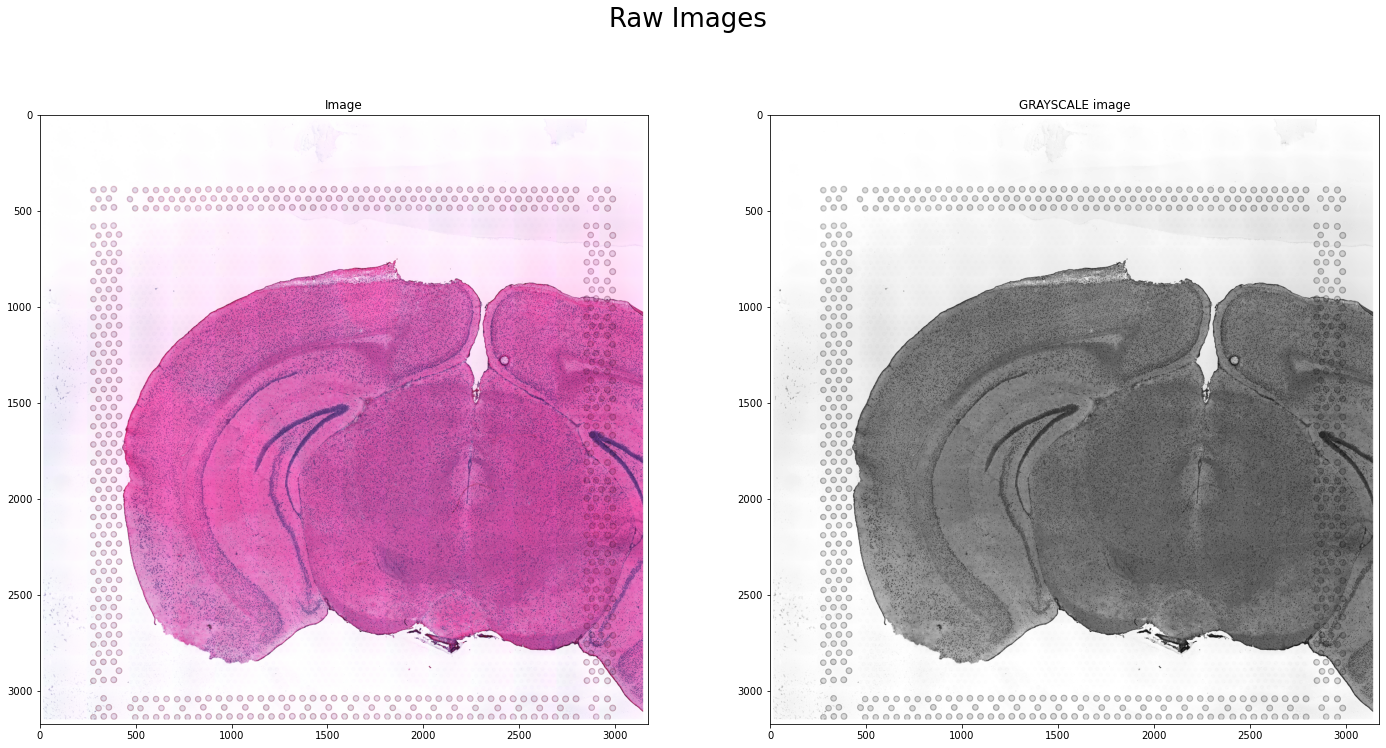

In [412]:
figure, axes = plt.subplots(ncols=2, figsize=(24, 12))
figure.suptitle("Raw Images", fontsize=26)
_ = axes[0].imshow(small_img)
_ = axes[1].imshow(small_img_GRAY, cmap='gray')
_ = axes[0].set_title("Image")
_ = axes[1].set_title("GRAYSCALE image")

Find the ROI_mask by:
1. thresholding
2. fill the gaps
3. select largest connected components

(3174, 3174) bool


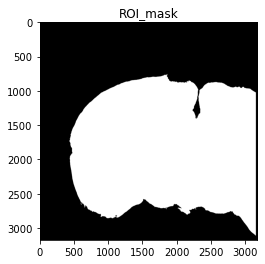

In [413]:
thresh = skimage.filters.threshold_otsu(small_img_GRAY)
small_ROI_mask = getLargestCC(scipy.ndimage.binary_fill_holes(small_img_GRAY < thresh))

print(small_ROI_mask.shape, small_ROI_mask.dtype)

plt.imshow(small_ROI_mask, cmap='gray')
_ = plt.title("ROI_mask")

Rescale the images appropriately and show the histogram.
Any global transformation is acceptable (i.e. historgram equalization etc). The importat thing is that the transformation can be expressed as a rule:

$\text{old_integer_value} \to \text{new_integer_value}$

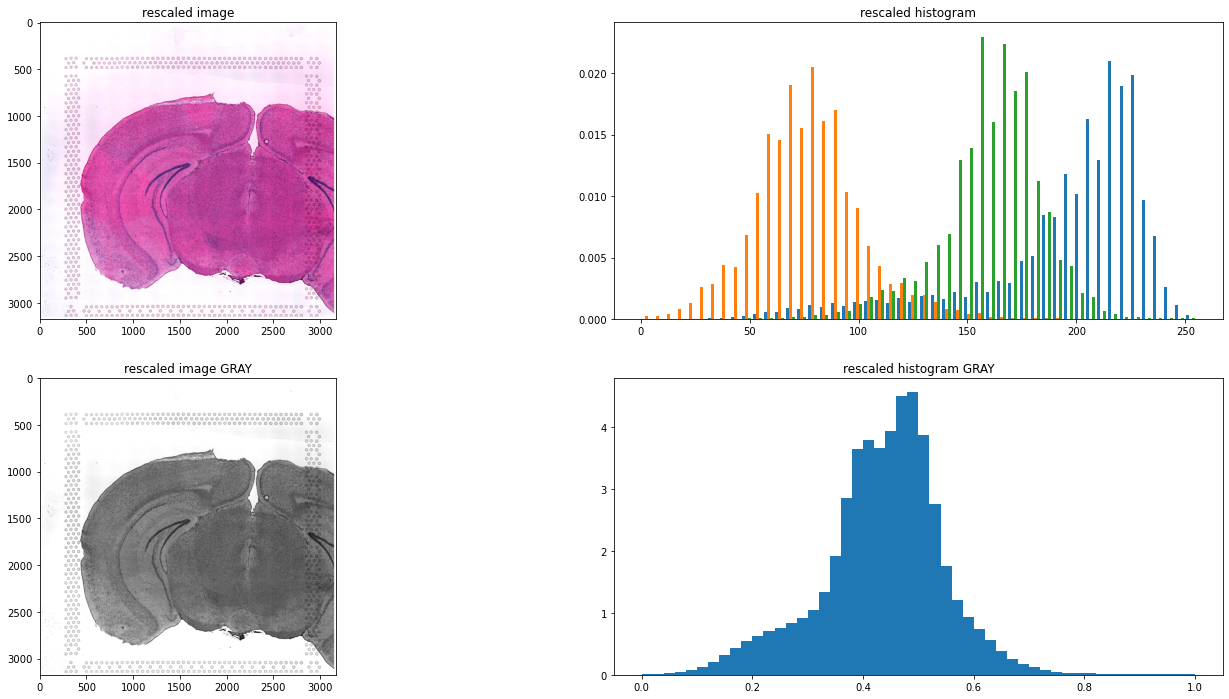

In [414]:
new_small = rescale_intensity(small_img, small_ROI_mask, q=(0.01, 99.99))
new_small_GRAY = rescale_intensity(small_img_GRAY, small_ROI_mask, q=(0.01, 99.99))

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 12))
_ = axes[0,0].imshow(new_small)
_ = axes[0,1].hist(new_small[small_ROI_mask], bins=50, density=True, range=(0,255))
_ = axes[1,0].imshow(new_small_GRAY, cmap='gray')
_ = axes[1,1].hist(new_small_GRAY[small_ROI_mask], bins=50, density=True, range=(0,1))
_ = axes[0,0].set_title("rescaled image")
_ = axes[0,1].set_title("rescaled histogram")
_ = axes[1,0].set_title("rescaled image GRAY")
_ = axes[1,1].set_title("rescaled histogram GRAY")

Show the transofrmation between old and new intensities

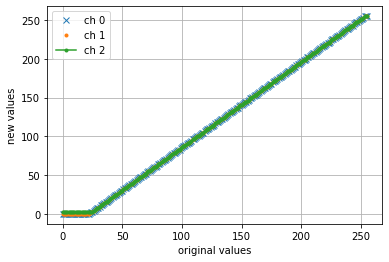

In [415]:
old_2_new_RGB = find_old_2_new(old=small_img[small_ROI_mask],
                               new=new_small[small_ROI_mask])
plt.plot(old_2_new_RGB[...,0], 'x', label="ch 0")
plt.plot(old_2_new_RGB[...,1], '.', label="ch 1")
plt.plot(old_2_new_RGB[...,2], '.-', label="ch 2")
plt.legend()
plt.xlabel("original values")
plt.ylabel("new values")
plt.grid()

Set the value outside ROI to either the image median or zero

In [416]:
mean_GRAY_channel_inside_ROI = np.mean(new_small_GRAY[small_ROI_mask])
mean_RGB_channel_inside_ROI = np.mean(new_small[small_ROI_mask], axis=-2).astype(int)

print("mean_GRAY_channel_inside_ROI",mean_GRAY_channel_inside_ROI)
print("mean_RGB_channel_inside_ROI",mean_RGB_channel_inside_ROI)

new_small_GRAY[~small_ROI_mask] = mean_GRAY_channel_inside_ROI
new_small[~small_ROI_mask] = mean_RGB_channel_inside_ROI

mean_GRAY_channel_inside_ROI 0.43508387912953733
mean_RGB_channel_inside_ROI [195  76 160]


Find the nuclei by performing an additional adaptive thresholdoing inside the ROI. Note that before adaptive thresholding we have set the value outside ROI to the mean inside ROI

In [417]:
thresh_v2 = skimage.filters.threshold_local(new_small_GRAY, 
                                            block_size=25, 
                                            method='mean', 
                                            offset=0, 
                                            mode='constant', 
                                            cval=0)
nuclei = (new_small_GRAY < thresh_v2 - 0.1) * small_ROI_mask

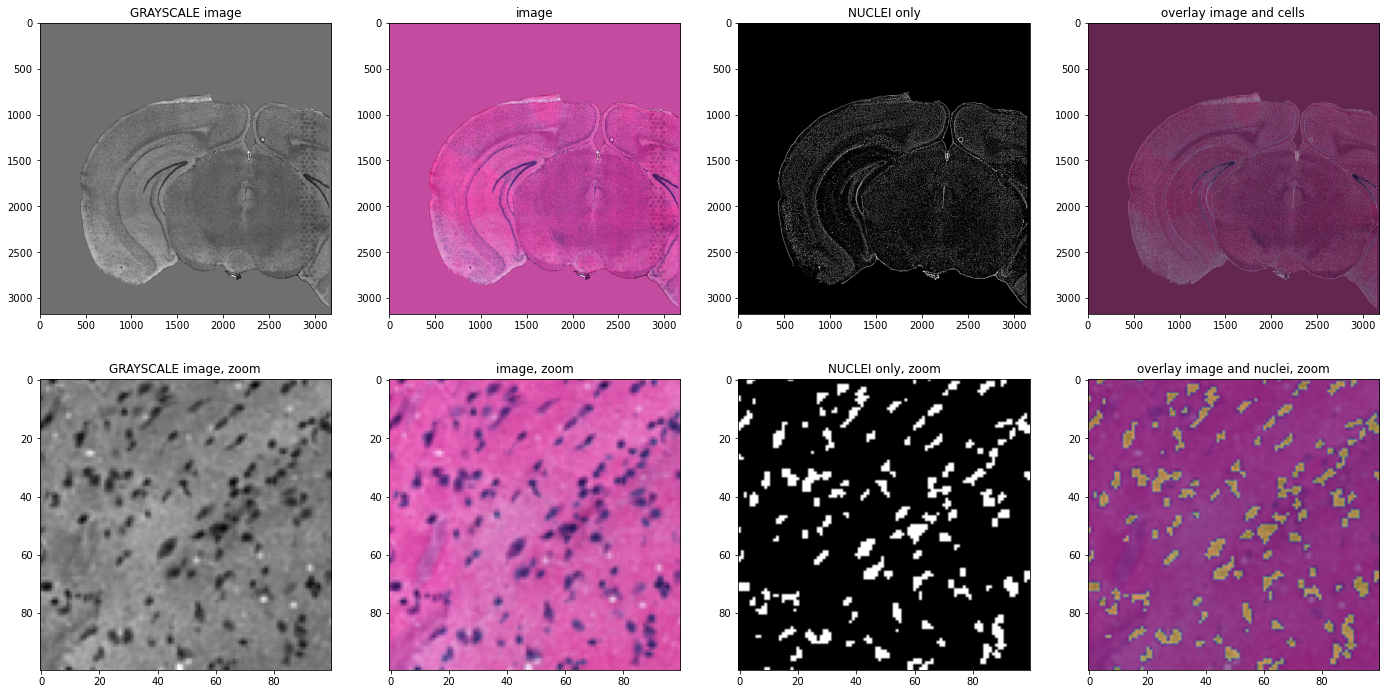

In [418]:
delta = 100
iw, ih = 2500, 2000
figure, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 12))
gray_img = axes[0,0]
img = axes[0,1]
instances = axes[0,2]
overlay = axes[0,3]

gray_img_zoom = axes[1,0]
img_zoom = axes[1,1]
instances_zoom = axes[1,2]
overlay_zoom = axes[1,3]

img.imshow(new_small)
gray_img.imshow(new_small_GRAY, cmap='gray')
instances.imshow(nuclei, cmap='gray')
overlay.imshow(new_small)
overlay.imshow(nuclei, alpha=0.5, cmap='gray')

img_zoom.imshow(new_small[iw:iw+delta,ih:ih+delta])
gray_img_zoom.imshow(new_small_GRAY[iw:iw+delta,ih:ih+delta], cmap='gray')
instances_zoom.imshow(nuclei[iw:iw+delta,ih:ih+delta], cmap='gray')
overlay_zoom.imshow(new_small[iw:iw+delta,ih:ih+delta])
overlay_zoom.imshow(nuclei[iw:iw+delta,ih:ih+delta], alpha=0.5)#, cmap='gray')

_ = img.set_title("image")
_ = img_zoom.set_title("image, zoom")
_ = gray_img.set_title("GRAYSCALE image")
_ = gray_img_zoom.set_title("GRAYSCALE image, zoom")
_ = instances.set_title("NUCLEI only")
_ = instances_zoom.set_title("NUCLEI only, zoom")
_ = overlay.set_title("overlay image and cells")
_ = overlay_zoom.set_title("overlay image and nuclei, zoom")

In [419]:
print("np.sum(nuclei) ------>",np.sum(nuclei))
print("np.sum(small_ROI_mask) ->",np.sum(small_ROI_mask))
print("Estimated fraction cell_pixel -->",float(np.sum(nuclei))/np.sum(small_ROI_mask))

np.sum(nuclei) ------> 566945
np.sum(small_ROI_mask) -> 4807362
Estimated fraction cell_pixel --> 0.11793266244564067


## Chose sigma for mean square error

Deteriorate the image by applying gaussian filter with increasing spatial support. Note that after the gaussian filters the image is converted to float in range (0,1)

In [420]:
gaussian_filter = np.arange(0,10)  # sigma=0 has no smoothing, i.e. original image
predictions = np.zeros([gaussian_filter.shape[0]]+list(new_small.shape))
multichannel = (len(new_small.shape)==3)
for n,s in enumerate(gaussian_filter):
    predictions[n] = skimage.filters.gaussian(new_small, sigma=s, multichannel=multichannel)

print(predictions.shape, predictions.dtype, np.min(predictions[0]),np.max(predictions[0]))

(10, 3174, 3174, 3) float64 0.0 1.0


Now I compute MSE of these deteriorated images.
The idea is to find a deteriorated image which is looking acceptable and fix sigma to that value.
Note that only values inside ROI are considered.


Demanding $ MSE = \frac{1}{W H C}\sum_{x,y,c} \left( \frac{\text{prediction} - \text{reference}}{\sigma}\right)^2 = 1$ 
implies that
$\sigma = \sqrt{ \frac{1}{W H C} \sum_{x,y,c} \left(\text{prediction} - \text{reference}\right)^2} $

In [421]:
sigma = compute_sqrt_mse(predictions, roi_mask=small_ROI_mask)

In [422]:
delta = 200
iw, ih = 2500, 2000
print(iw,ih,delta)

show_video(frames=predictions[:,iw:iw+delta,ih:ih+delta], 
           ref_image=new_small[iw:iw+delta,ih:ih+delta],
           sigma=sigma,
           interval=500)

2500 2000 200


# High resolution images
Apply the transformations determined using the small resolution images

Open the image in native resolution. 
Upsample the small_ROI_mask to the native resolution. This is faster than extracting the ROi_mask directly from the native resolution image

In [423]:
large_img = pil_to_numpy_int(file, mode=mode, reduction_factor=1)
large_ROI_mask = skimage.transform.resize(small_ROI_mask, 
                                          output_shape=large_img.shape[0:2], 
                                          order=0).astype(bool)

PIPELINE IS:
1. Crop the image to the region of interest with a tigh bounding box
2. Scale the intensities with old_2_new_RGB
3. set the value outside ROI to either zero or image mean inside ROI

In [424]:
bbox_original= BBOX(min_row=0,
                    min_col=0,
                    max_row=large_ROI_mask.shape[0],
                    max_col=large_ROI_mask.shape[1])
bbox_crop = find_bbox(large_ROI_mask)
bbox_crop_debug = find_bbox(small_ROI_mask)

print(bbox_original)
print(bbox_crop)
print(bbox_crop_debug)

cropped_img = large_img[bbox_crop.min_row:bbox_crop.max_row,
                        bbox_crop.min_col:bbox_crop.max_col]
cropped_ROI_mask = large_ROI_mask[bbox_crop.min_row:bbox_crop.max_row,
                                  bbox_crop.min_col:bbox_crop.max_col]

BBOX(min_row=0, min_col=0, max_row=31744, max_col=31744)
BBOX(min_row=7571, min_col=4281, max_row=31114, max_col=31434)
BBOX(min_row=757, min_col=428, max_row=3111, max_col=3143)


In [425]:
new_large = np.copy(cropped_img)
for c in range(cropped_img.shape[2]):
    print(c)
    new_large[...,c] = old_2_new_RGB[cropped_img[...,c],c]

0
1
2


In [426]:
new_large[~cropped_ROI_mask] = mean_RGB_channel_inside_ROI

Visualize few examples

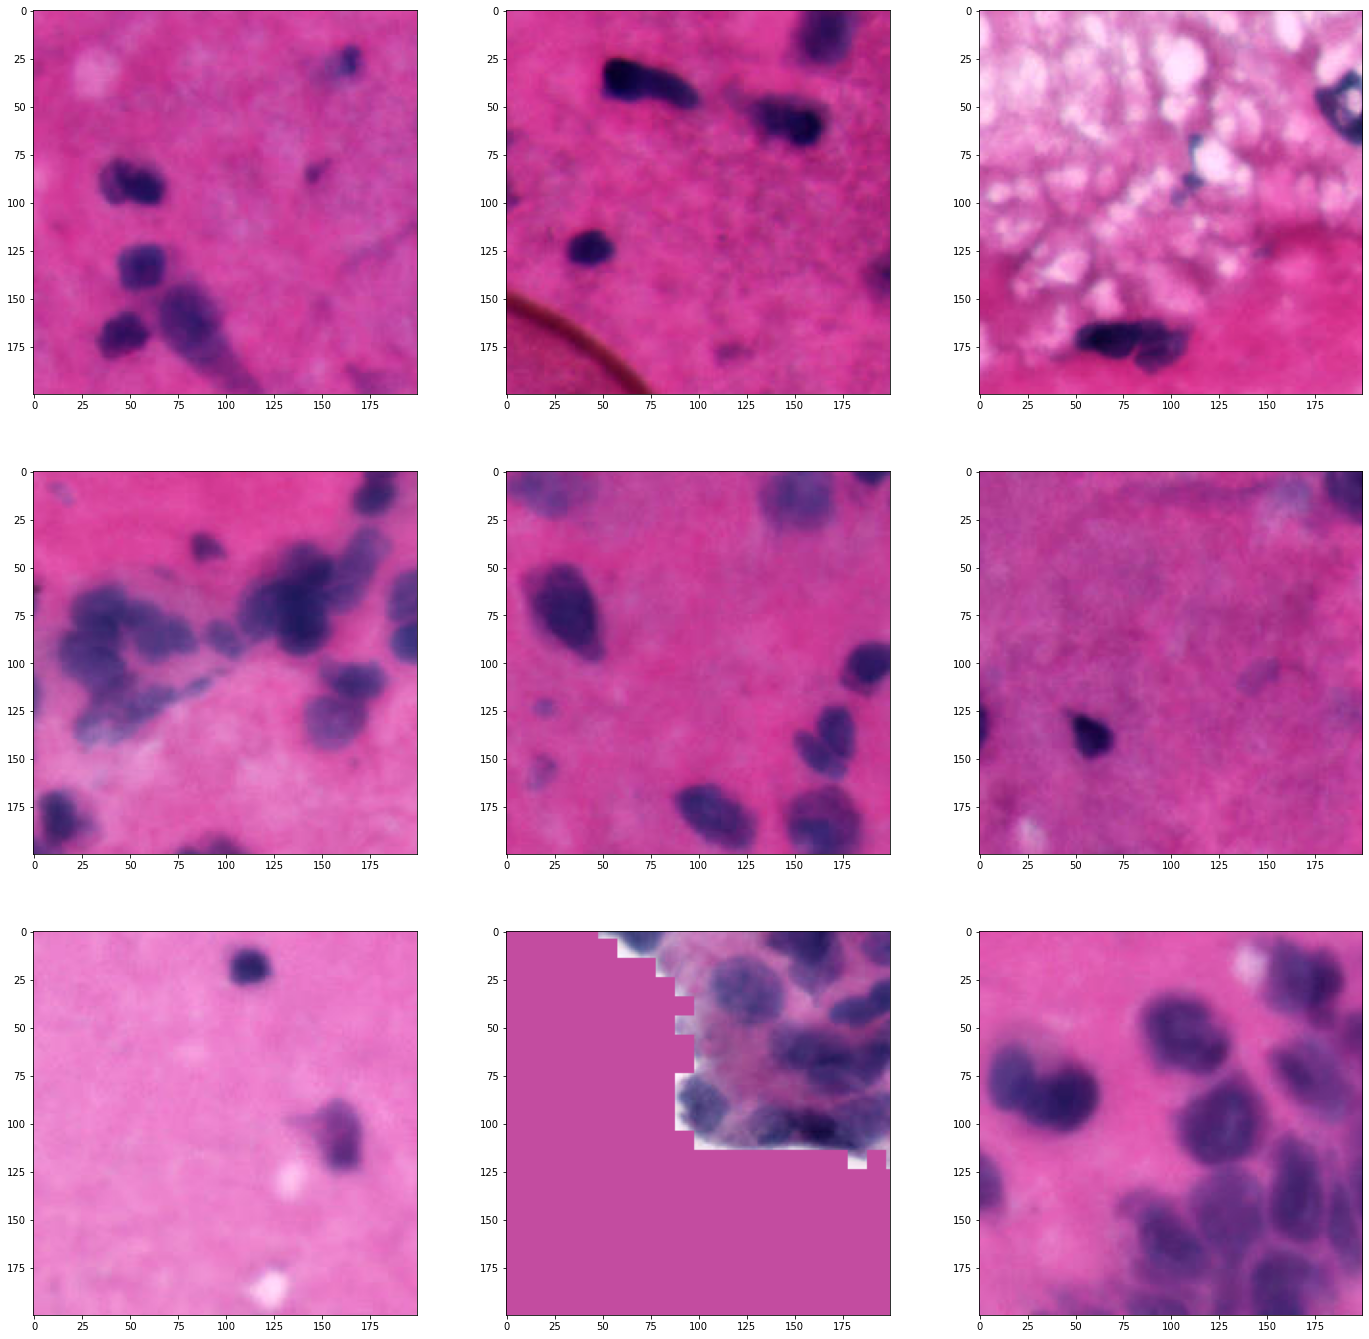

In [427]:
N_examples = 9
ncols=3
nrows=int(np.ceil(N_examples/ncols))
delta = 200
iw_array = np.random.randint(low=0, high=cropped_ROI_mask.shape[-2]-delta, size=N_examples, dtype=int)
ih_array = np.random.randint(low=0, high=cropped_ROI_mask.shape[-1]-delta, size=N_examples, dtype=int)
#print(iw,ih)

figure, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(24, 24))
for n in range(N_examples):
    r = int(n / ncols)
    c = np.mod(n,ncols)
    axes[r,c].imshow(new_large[iw_array[n]:iw_array[n]+delta,
                               ih_array[n]:ih_array[n]+delta])

From these images I see that cells have a typical size of 25.
To be safe I set the cell size in the range 15-45.
We also see that in a window of size 200x200 there are no more than 30 nuclei

In [428]:
f = "preprocessed_"+file
tmp=PREPROCESS(img=cropped_img,
               roi_mask=cropped_ROI_mask,
               bbox_original=bbox_original,
               bbox_crop=bbox_crop)
torch.save(tmp, f)

# Conclusion 

We have:
1. generated a cropped version of the image and the mask
2. figured out that the fraction of pixel belonging to the nuclei is about 15
3. a reasonable value for sigma to use in the MSE is 0.05
4. the nuclei have a linear size in the range 15-45 pixels
5. in a window of 200x200 pixel we expect no more that 30 nuclei